In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RB_Sentence1_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list)) 

Positive : 5775
Neutral : 133685
Negative : 748


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1148


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Museums'][df1['TextBlob Polarity RBS1'] > 0]['RB_Sentence1'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I wouldnt plan your afternoon on this museum - its poorly lighted/laid out, '
 'but as its close to the Ethnological Museum, its probably ok to have a '
 'look-in before/after that!']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['wouldnt', 'plan', 'your', 'afternoon', 'on', 'this', 'museum', 'its', 'poorly', 'lighted', 'laid', 'out', 'but', 'as', 'its', 'close', 'to', 'the', 'ethnological', 'museum', 'its', 'probably', 'ok', 'to', 'have', 'look', 'in', 'before', 'after', 'that']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['wouldnt', 'plan', 'your', 'afternoon', 'on', 'this', 'museum', 'its', 'poorly', 'lighted', 'laid_out', 'but', 'as', 'its', 'close', 'to', 'the', 'ethnological', 'museum', 'its', 'probably', 'ok', 'to', 'have', 'look', 'in', 'before', 'after', 'that']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['would', 'plan', 'afternoon', 'poorly', 'light', 'lay', 'close', 'ethnological', 'probably', 'look']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('afternoon', 1),
  ('close', 1),
  ('ethnological', 1),
  ('lay', 1),
  ('light', 1),
  ('look', 1),
  ('plan', 1),
  ('poorly', 1),
  ('probably', 1),
  ('would', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"know" + 0.047*"information" + 0.039*"need" + 0.032*"different" + '
  '0.031*"little" + 0.029*"picture" + 0.029*"stop" + 0.026*"read" + '
  '0.022*"piece" + 0.022*"city"'),
 (1,
  '0.108*"old" + 0.095*"find" + 0.059*"human" + 0.047*"famous" + '
  '0.037*"million_year" + 0.027*"archaeological" + 0.024*"fossil" + '
  '0.024*"period" + 0.022*"explanation" + 0.022*"include"'),
 (2,
  '0.067*"well" + 0.060*"small" + 0.052*"culture" + 0.050*"lot" + '
  '0.040*"spend" + 0.035*"hour" + 0.032*"learn" + 0.031*"art" + 0.023*"quite" '
  '+ 0.023*"emperor"'),
 (3,
  '0.085*"go" + 0.074*"worth" + 0.059*"time" + 0.045*"give" + 0.038*"first" + '
  '0.033*"trip" + 0.033*"thing" + 0.021*"come" + 0.020*"bit" + 0.019*"long"'),
 (4,
  '0.083*"really" + 0.052*"much" + 0.046*"collection" + 0.033*"artifact" + '
  '0.030*"exhibit" + 0.028*"floor" + 0.028*"tell" + 0.027*"university" + '
  '0.026*"remain" + 0.025*"locate"'),
 (5,
  '0.097*"guide" + 0.047*"part" + 0.043*"informative" + 0.032*"especi

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2626089425579385

Coherence Score:  0.5060085488097555


In [17]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('history', 0.21397379912663755),
   ('learn', 0.0611353711790393),
   ('art', 0.049490538573508006),
   ('important', 0.040756914119359534),
   ('red', 0.03784570596797671),
   ('trip', 0.034934497816593885),
   ('year', 0.03202328966521106),
   ('read', 0.03056768558951965),
   ('begin', 0.01601164483260553),
   ('cover', 0.01601164483260553)]),
 (1,
  [('collection', 0.0743801652892562),
   ('remain', 0.05647382920110193),
   ('early', 0.04132231404958678),
   ('historical', 0.03581267217630854),
   ('cultural', 0.03168044077134986),
   ('stop', 0.030303030303030304),
   ('artifact', 0.024793388429752067),
   ('make', 0.02203856749311295),
   ('set', 0.02203856749311295),
   ('hominid', 0.02066115702479339)]),
 (2,
  [('worth', 0.1228813559322034),
   ('visit', 0.0692090395480226),
   ('spend', 0.059322033898305086),
   ('hour', 0.05790960451977401),
   ('day', 0.05508474576271186),
   ('tour', 0.04943502824858757),
   ('story', 0.0423728813559322),
   ('understand', 0.03813

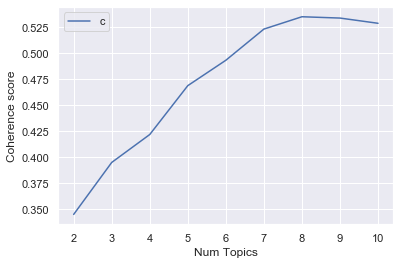

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3452
Num Topics = 3  has Coherence Value of 0.3952
Num Topics = 4  has Coherence Value of 0.422
Num Topics = 5  has Coherence Value of 0.469
Num Topics = 6  has Coherence Value of 0.4934
Num Topics = 7  has Coherence Value of 0.5234
Num Topics = 8  has Coherence Value of 0.5352
Num Topics = 9  has Coherence Value of 0.5339
Num Topics = 10  has Coherence Value of 0.5289


In [20]:
# optimal_model = model_list[6] # Number of Topics = 8

optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.085*"guide" + 0.048*"floor" + 0.048*"spend" + 0.043*"day" + 0.041*"hour" '
  '+ 0.038*"experience" + 0.026*"cultural" + 0.026*"tour" + 0.025*"city" + '
  '0.024*"work"'),
 (1,
  '0.093*"exhibit" + 0.093*"visit" + 0.092*"small" + 0.062*"culture" + '
  '0.034*"tribe" + 0.023*"find" + 0.020*"stop" + 0.018*"set" + 0.017*"end" + '
  '0.017*"item"'),
 (2,
  '0.120*"display" + 0.051*"find" + 0.044*"basement" + 0.035*"university" + '
  '0.033*"locate" + 0.031*"explanation" + 0.029*"picture" + 0.028*"year" + '
  '0.026*"important" + 0.023*"expect"'),
 (3,
  '0.094*"time" + 0.083*"human" + 0.051*"give" + 0.051*"people" + '
  '0.037*"evolution" + 0.036*"understand" + 0.034*"main" + 0.034*"live" + '
  '0.028*"bit" + 0.028*"fossil"'),
 (4,
  '0.072*"lot" + 0.046*"art" + 0.045*"information" + 0.037*"life" + '
  '0.034*"story" + 0.031*"show" + 0.028*"emperor" + 0.022*"real" + 0.020*"red" '
  '+ 0.020*"part"'),
 (5,
  '0.124*"worth" + 0.047*"make" + 0.044*"exhibition" + 0.044*"learn" + '
  '

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1447,"exhibit, visit, small, culture, tribe, find, s...",I wouldnt plan your afternoon on this museum -...
1,1,3.0,0.1394,"time, human, give, people, evolution, understa...",great to see such old fossils...very education...
2,2,0.0,0.1507,"guide, floor, spend, day, hour, experience, cu...","in addis, i place to go, i visit to lucy and o..."
3,3,2.0,0.1343,"display, find, basement, university, locate, e...","am a museum person , i love history any any th..."
4,4,3.0,0.1343,"time, human, give, people, evolution, understa...",really a bit neglected even though it has some...
5,5,2.0,0.1368,"display, find, basement, university, locate, e...",very informative although i think that the rea...
6,6,1.0,0.1545,"exhibit, visit, small, culture, tribe, find, s...",Maybe I get more out of reading about thngs th...
7,7,1.0,0.1368,"exhibit, visit, small, culture, tribe, find, s...",A touching memorial of a trying time in Ethiop...
8,8,1.0,0.1394,"exhibit, visit, small, culture, tribe, find, s...","Small museum, very well worth a visit."
9,9,4.0,0.1416,"lot, art, information, life, story, show, empe...",This is the real gem.


In [22]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    329
2.0    217
1.0    213
5.0    183
7.0    175
6.0    166
3.0    159
4.0    150
Name: Dominant_Topic, dtype: int64

In [30]:
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Museum Guide - 329
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Interest on Exhibits - 213 
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Commending the Organization - 217
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # General Appreciation - 159
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Appreciation - 150
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # General Appreciation - 183
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Interest on Exhibits - 166
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # General Appreciation - 175

array(['excellent representation from orgin of man kind to recent Ethiopia, i love it but the building must be changed it is small to represent the whole country',
       'For me this visit allowed me to relate some of the historical facts I knew to real articles, therefore evidencing what I knew theoretically.',
       'Its a good place to visit and know more about Ethiopia, its history and actually about the history of the human kind.',
       'a nice way to spend 30 minutes- the guide was hyped up on chat and rattled off the history of everything in record time (which was fine with me).',
       'The museum gives an interesting and impressive overview on a part of Ethiopias history.',
       'Really interesting museum about the darker side of Ethiopian history.',
       'If you are interested in modern Ethiopian history then you must visit the Red Terror museum.',
       'Visit this museum is a nice start for a trip to Ethiopia.. its fascinating history and its ancient culture.',
  

In [34]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2209,"guide, floor, spend, day, hour, experience, cu...","Situated in one of the last Emperors palaces, ..."
1,1.0,0.1940,"exhibit, visit, small, culture, tribe, find, s...",This museum has seen better days - the exhibit...
2,2.0,0.2122,"display, find, basement, university, locate, e...",The prehistoric bones and Lucy were great disp...
3,3.0,0.1995,"time, human, give, people, evolution, understa...",I have been to this important Museum to catch ...
4,4.0,0.2042,"lot, art, information, life, story, show, empe...","Small gallery, expertly run by Lilly who has b..."
5,5.0,0.1915,"worth, make, exhibition, learn, artifact, piec...",the museum is free but you can make a donation...
6,6.0,0.2457,"collection, remain, include, famous, informati...",The museum contain some of the most precious a...
7,7.0,0.1976,"history, country, thing, trip, period, modern,...",Spent about an hour in here after a two week t...


In [35]:
sent_topics_sorteddf_mallet['Text'].values

array(['Situated in one of the last Emperors palaces, the exhibits are arranged over a couple of floors, not at all busy, we had a guide who was very knowledgeable and we spent a couple of hours strolling around - fascinating, recommended.',
       'This museum has seen better days - the exhibits are poorly lit..... Our guide told us that the Lucy we were looking at is actually a reproduction - her original resides in a library.',
       'The prehistoric bones and Lucy were great displays on the first floor ....after that it was all downhill....top 3 floors get worse as you walk thru....Not very well maintained displays....Not very organized....Not much of explanation of displayed items deeper you get into the museum....',
       'I have been to this important Museum to catch the diverse life style with the well organised collections of reaserched inputs,descriptions of the ppl lifestyle,tools,Commons,differnces....more, within the Jinka uphill culturally harmonised building also gives

In [36]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics